In [46]:
import random
import lr_scheduler
import matplotlib.pyplot as plt
#from func import *
import func
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler


folder_path = "F:/code/barlow/UR5"
file_pairs = func.load_file_pairs(folder_path)

In [47]:
AUTO = tf.data.AUTOTUNE
CROP_TO = 32
SEED = 42

PROJECT_DIM = 2048
BATCH_SIZE = 32
EPOCHS = 20

In [48]:
images = []
npy_file = []
for jpg_path, npy_path in file_pairs:
    images.append(func.read_jpg_files(jpg_path))
    npy_file.append(func.read_and_parse_npy_file(npy_path))
    

In [49]:
# No1. Augmentation Functions
def augment_image(image):
    if random.random() > 0.5:
        image = np.fliplr(image) # Lật trái-phải
    if random.random() > 0.5:
        image = np.flipud(image) # Lật trên-dưới
    
    crop_size = random.randint(5, 20)
    h, w = image.shape
    cropped_image = image[crop_size:h-crop_size, crop_size:w-crop_size]
    # Resize lại về kích thước ban đầu
    augmented_image = np.pad(cropped_image, ((crop_size, crop_size), (crop_size, crop_size)), mode='constant', constant_values=77)
    return augmented_image

# No2. Augmentation Functions
def adjust_brightness(image, factor=1.2):
    """
    Scale pixel values and clip to ensure values stay within [0, 255]
    """
    adjusted = np.clip(image * factor, 0, 255).astype(np.uint8)
    return adjusted

def add_noise_vector(vector,alpha= 0.01):
    noise = np.random.normal(0, alpha, size=len(vector)) # Nhiễu với độ lệch chuẩn alpha
    augmented_vector = [v + n for v, n in zip(vector, noise)]
    #augmented_vector = [i.astype(float) for i in augmented_vector]
    return augmented_vector


In [50]:
# image
image1 = [augment_image(img) for img in images]
image2 = [adjust_brightness(img, factor=1.1) for img in images]

# noise
npy_file_1 = [add_noise_vector(i,alpha= 0.01) for i in npy_file]
npy_file_2 = [add_noise_vector(i,alpha= 0.02) for i in npy_file]

In [52]:
# Normalize
image1 = [(i.astype("float32") / 255.0) for i in image1]
image2 = [(i.astype("float32") / 255.0) for i in image2]

scaler = StandardScaler()
npy_file_1 = scaler.fit_transform(npy_file_1)
npy_file_2 = scaler.fit_transform(npy_file_2)


In [53]:
dataset1 = tf.data.Dataset.from_tensor_slices((image1, npy_file_1))
dataset2 = tf.data.Dataset.from_tensor_slices((image2, npy_file_2))

In [54]:
# Batch và prefetch
dataset1 = (
    dataset1
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
dataset2 = (
    dataset2
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

BL_ds = tf.data.Dataset.zip((dataset1, dataset2))

In [55]:
STEPS_PER_EPOCH = 597 // BATCH_SIZE
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.1)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

lr_decayed_fn = lr_scheduler.WarmUpCosine(
    learning_rate_base=1e-4,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_learning_rate=0.0,
    warmup_steps=WARMUP_STEPS
)

In [56]:
def concat_encoder():
    # Input đầu vào cho ảnh và npy_file
    image_input = layers.Input(shape=(128, 128, 1), name="image_input")  # Đầu vào ảnh 128x128x1
    npy_input = layers.Input(shape=(8,), name="npy_input")  # Đầu vào npy_file shape (8,)

    # x1: CNN đọc ảnh 128x128 và trả output shape (20)
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
    x1 = layers.MaxPooling2D((2, 2))(x1)
    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x1 = layers.MaxPooling2D((2, 2))(x1)
    x1 = layers.Flatten()(x1)
    x1 = layers.Dense(20, activation='relu', name="cnn_output")(x1)

    # x2: Đọc npy_file với shape (8)
    # x2 = layers.Dense(8, activation='relu', name="npy_output")(npy_input)
    # x3: Kết hợp x1 + x2
    #x3 = layers.Concatenate(name="combined_features")([x1, x2])
    
    # Đọc thẳng npy_file với shape (8)
    x3 = layers.Concatenate(name="combined_features")([x1, npy_input])

    # Fully connected layers
    x = layers.Dense(128, activation="relu", name="dense_128")(x3)
    x = layers.Dense(64, activation="relu", name="dense_64")(x)
    x = layers.Dense(32, activation=None, name="projection_head")(x)  # Projection head

    # Model
    model = models.Model(inputs=[image_input, npy_input], outputs=x, name="encoder")
    return model

BL_ds_test = BL_ds

# 2. Tạo mô hình Barlow Twins
encoder = concat_encoder()
barlow_twins = func.BarlowTwins(encoder=encoder)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
barlow_twins.compile(optimizer=optimizer)
history = barlow_twins.fit(BL_ds_test, epochs=EPOCHS)

Epoch 1/20


f:\code\barlow\env\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'npy_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 1.3693
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 1.2920
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 1.2291
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 1.1990
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 1.1317
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 1.0786
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 1.0410
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 1.0167
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.9991
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.9856
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.9751
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.9668
Epoch 13/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.9603
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.9554
Epoch 15/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.9518


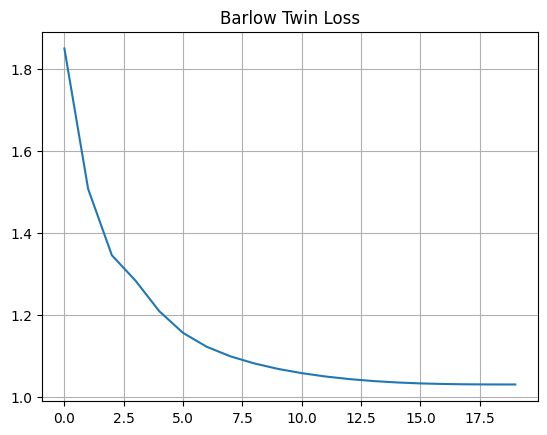

In [57]:
plt.plot(history.history["loss"])
plt.grid()
plt.title("Barlow Twin Loss")
plt.show()

In [ ]:
# Save
#barlow_twins.save_weights('bl_test2.weights.h5')

In [59]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 65536)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_output (Dense)  │ (None, 20)        │  1,310,740 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ npy_input           │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_features   │ (None, 28)        │          0 │ cnn_output[0][0], │
│ (Concatenate)       │                   │            │ npy_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_128 (Dense)   │ (None, 128)       │      3,712 │ combined_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 64)        │      8,256 │ dense_128[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ projection_head     │ (None, 32)        │      2,080 │ dense_64[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,343,604 (5.13 MB)

 Trainable params: 1,343,604 (5.13 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
barlow_twins.summary()

Model: "barlow_twins_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ (None, 32)             │     1,343,604 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,687,209 (10.25 MB)

 Trainable params: 1,343,604 (5.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,343,605 (5.13 MB)